In [33]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

In [168]:
def evaluate_function_sine(x, k ,c):
    return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
def evaluate_basis_sine(x,c):
    # The frequency starts at 1
    frequencies = jnp.arange(1, c.shape[0] +1)
    return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

In [ ]:
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[::-1] # remove the last element which is zero

In [191]:

def discrete_sine_transform(y):
    """
    y is the vector of coefficents of size n. It assumes that it only contains the frequencies 1,2,3,...,n. (no zero frequency)
    returns evaluation of the sine series at the points 1,2,3,...,n (no zero point)
    """
    n = y.shape[0]
    y_extended = jnp.concatenate([jnp.zeros(1), y, jnp.zeros(1), -y[::-1]])
    y_fft = jnp.fft.fft(y_extended)/2
    return (-y_fft.imag)[1: n+1]*jnp.sqrt(2)

def compute_sine_coefficients(y):
    n = y.shape[0]
    return discrete_sine_transform(y)/(n+1)

In [181]:
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**10
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:]
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))]) 
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

1024


In [195]:
u_values_dct = discrete_sine_transform(coef_u)

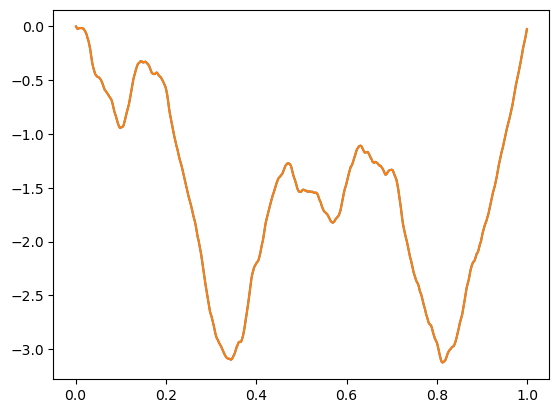

In [200]:
plt.plot(domain_finest, u_values)
plt.plot(domain_finest, u_values_dct)

In [194]:
compute_sine_coefficients(u_values), compute_sine_coefficients(u_values_dct)

(Array([-1.59053696e+00,  1.86124965e-01, -4.46838235e-01, ...,
         8.98179769e-06,  2.04883469e-05,  1.57002229e-06], dtype=float64),
 Array([-1.59053696e+00,  1.86124965e-01, -4.46838235e-01, ...,
         8.98179769e-06,  2.04883469e-05,  1.57002229e-06], dtype=float64))

In [198]:
jnp.mean(jnp.abs(u_values - u_values_dct)), jnp.mean(jnp.abs(coef_u - compute_sine_coefficients(u_values))), jnp.mean(jnp.abs(coef_u - compute_sine_coefficients(u_values_dct)))

(Array(6.84687224e-16, dtype=float64),
 Array(1.96013526e-17, dtype=float64),
 Array(1.32087279e-17, dtype=float64))

In [199]:
f_values_dct = discrete_sine_transform(coef_f)

In [205]:
jnp.mean(jnp.abs(f_values - f_values_dct)), jnp.mean(jnp.abs(coef_f - compute_sine_coefficients(f_values))), jnp.mean(jnp.abs(coef_f - compute_sine_coefficients(f_values_dct)))

(Array(1.87700007e-12, dtype=float64),
 Array(6.49090288e-14, dtype=float64),
 Array(2.69078862e-16, dtype=float64))

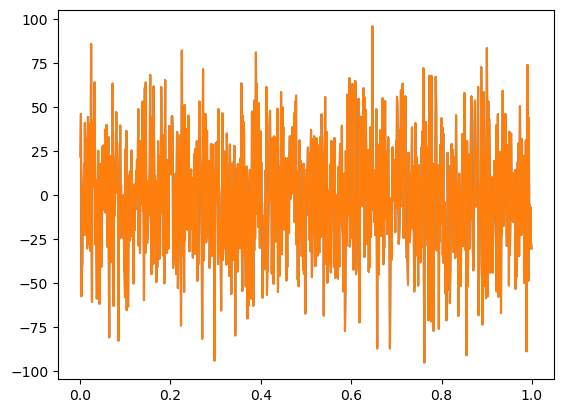

In [201]:
plt.plot(domain_finest, f_values)
plt.plot(domain_finest, f_values_dct)

In [163]:
plt.style.use('default')

In [174]:
n_coef = 2**10
print(n_coef)
coef_test = jnp.zeros(n_coef)

freq = 2
coef_test = coef_test.at[freq-1].set(1.0)
coef_test

1024


Array([0., 1., 0., ..., 0., 0., 0.], dtype=float64)

In [175]:
discrete_sine_transform(coef_test)

Array([ 0.00866899,  0.01733765,  0.02600565, ..., -0.02600565,
       -0.01733765, -0.00866899], dtype=float64)

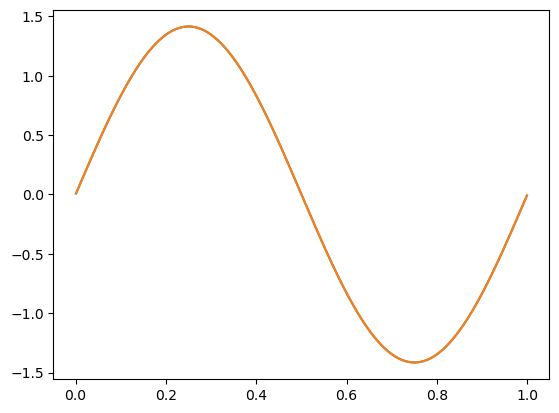

In [176]:
plt.plot(domain, evaluate_function_sine(domain, freq ,1))
plt.plot(domain, discrete_sine_transform(coef_test))

In [178]:
jnp.mean(jnp.abs(evaluate_function_sine(domain, freq ,1) - discrete_sine_transform(coef_test)))

Array(2.69108297e-16, dtype=float64)

In [166]:
domain = jnp.linspace(0, 1, n_coef+1, endpoint=False)[1:]

In [169]:
evaluate_basis_sine(domain,coef_test)

Array([ 0.01733765,  0.03467268,  0.05200251, ..., -0.05200251,
       -0.03467268, -0.01733765], dtype=float64)

In [167]:
values = evaluate_basis_sine(domain, coef_test)

In [160]:
j = 1
jnp.sin(jnp.pi*j*freq/n_coef), values

(Array(0.01227154, dtype=float64, weak_type=True),
 Array([0.01300338, 0.02600565, 0.03900573, ..., 0.03900573, 0.02600565,
        0.01300338], dtype=float64))

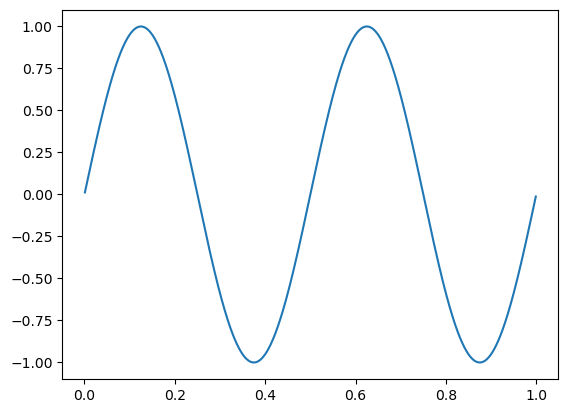

In [152]:
plt.plot(domain, discrete_sine_transform(coef_test))

In [132]:
dst_jax(coef_test[:]), discrete_sine_transform(coef_test)

(Array([ 0.,  1.,  2.,  3.,  4.,  0., -4., -3., -2., -1.], dtype=float64),
 Array([ 0.,  1.,  2.,  3.,  4.,  0., -4., -3., -2., -1.], dtype=float64))

In [130]:
domain = jnp.linspace(0, 1, n_coef, endpoint=False)
test_values = inverse_sine_transform(coef_test[:])
#test_values = dst_jax(coef_test[1:])

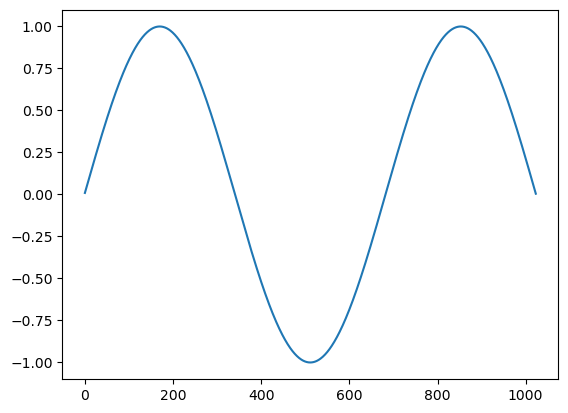

In [120]:
plt.plot(test_values)

In [14]:
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**13
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
print(n_coef)

frequencies = jnp.arange(0, n_coef)
coef_f = jnp.hstack([0.0, random.normal(key, shape= (n_coef-1,))]) # We set the first coefficient to zero as it corresponds to the constant term
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

8192


In [17]:
t = inverse_sine_transform(coef_u)
plt.plot(t)

Error in callback <function _draw_all_if_interactive at 0x000001A50634FE20> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1920x1440 with 1 Axes>

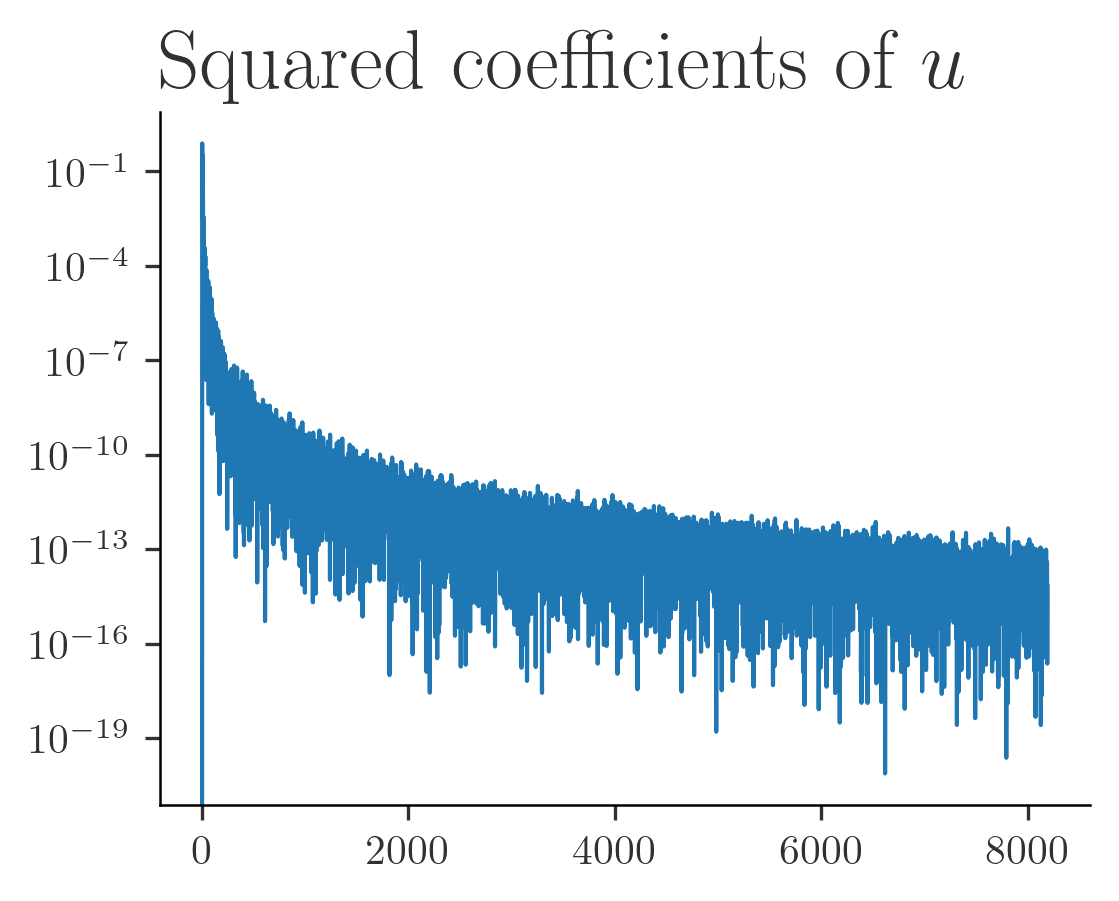

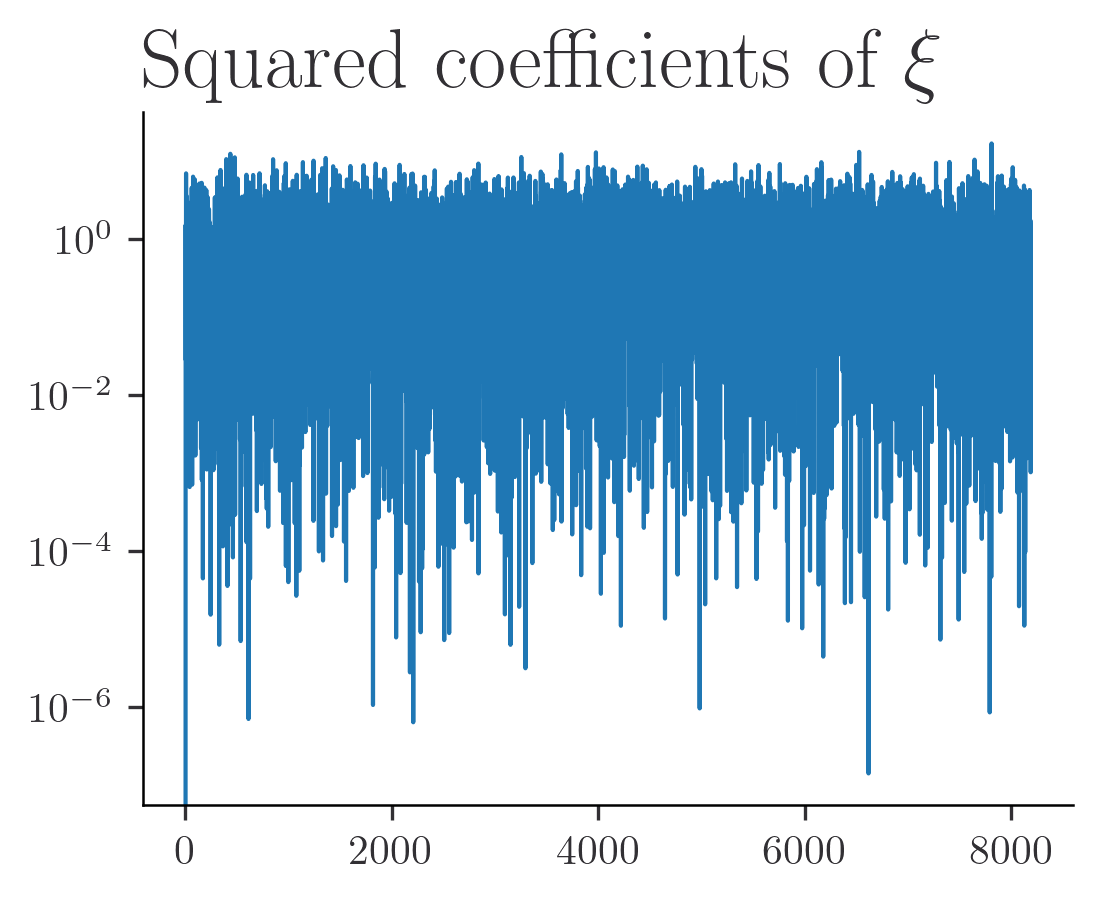

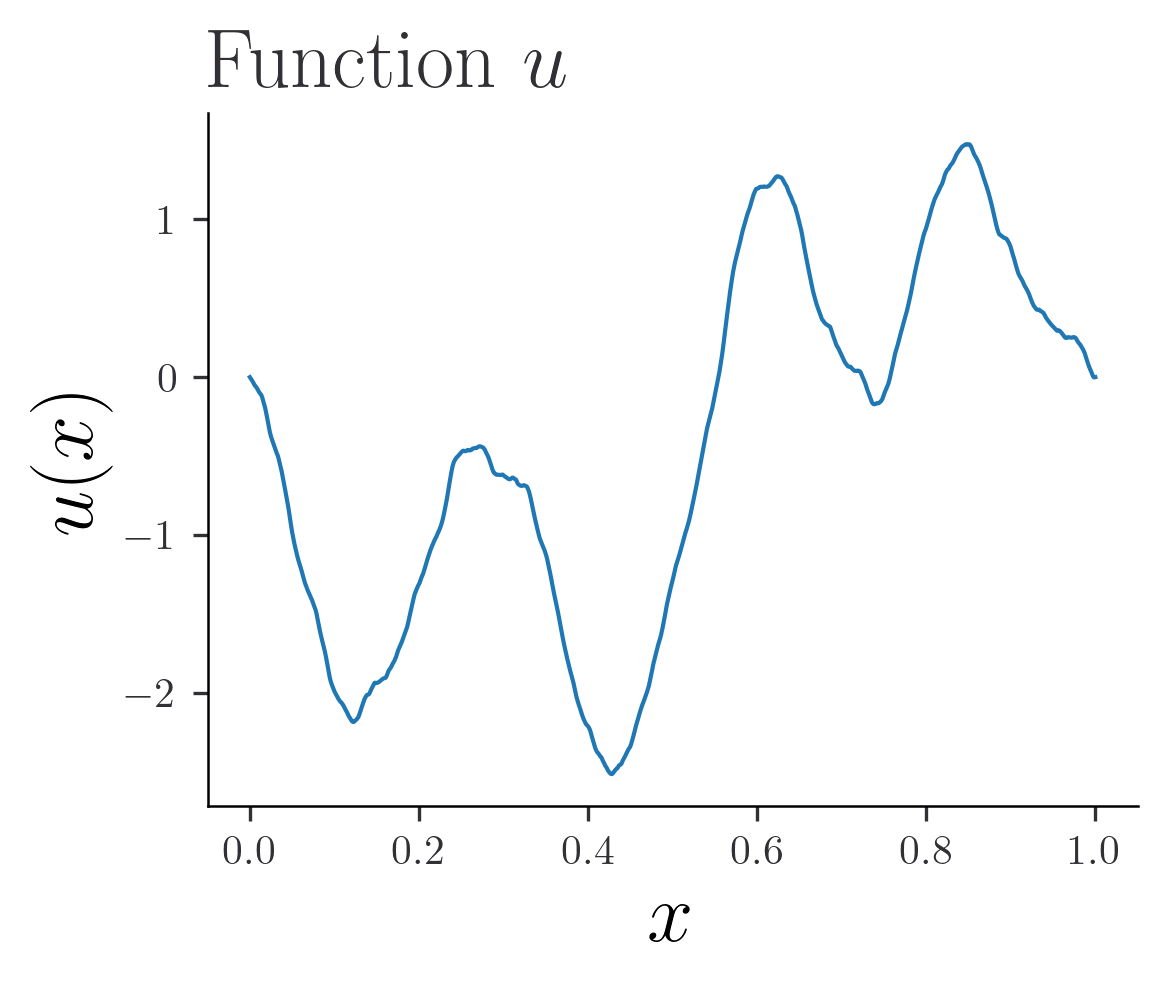

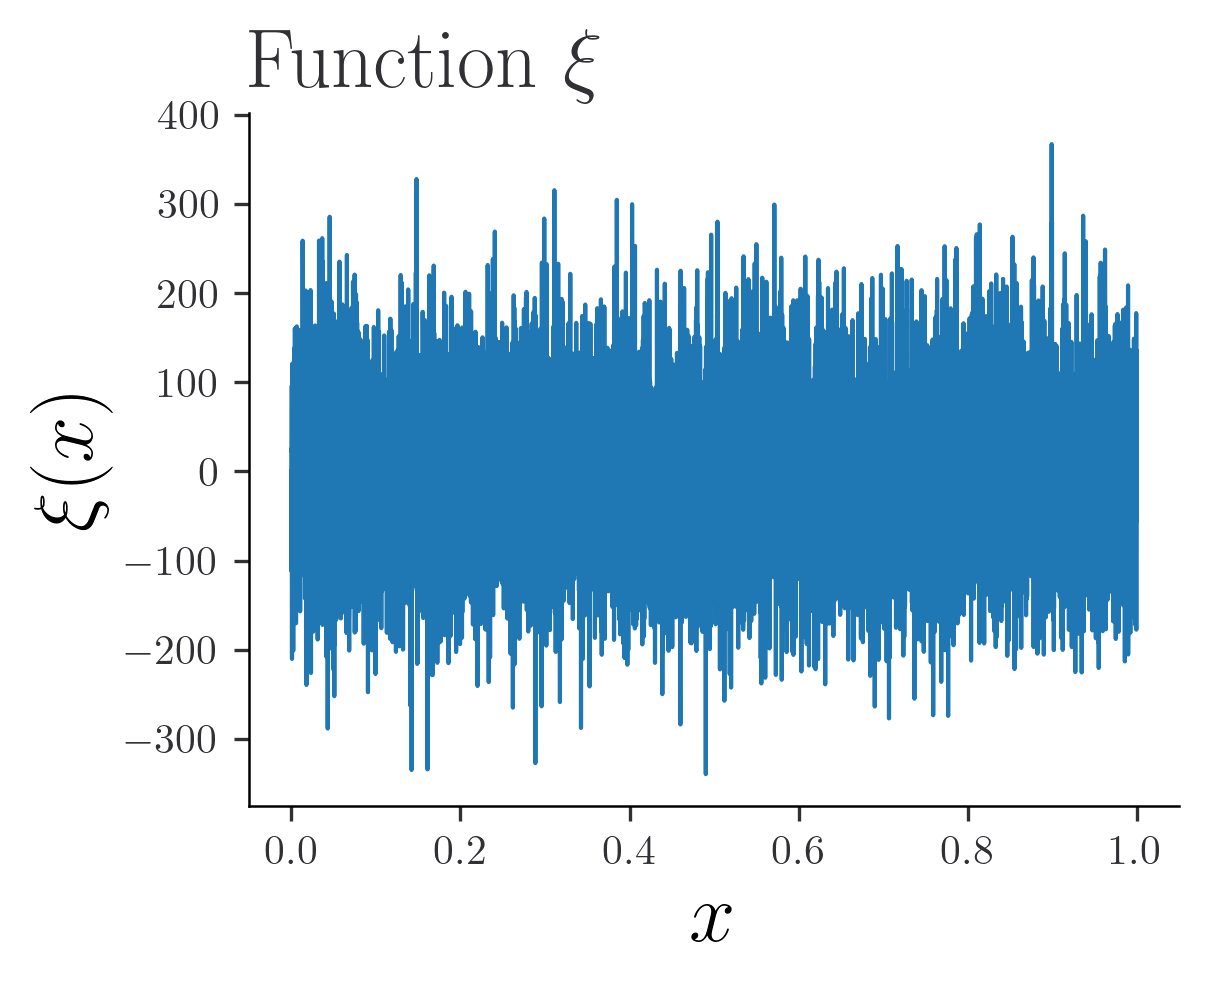

In [ ]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [18]:
n_coef = 2**10
print(n_coef)
coef_test = jnp.zeros(n_coef)
#coef_test = coef_test.at[1].set(1.0)
freq = 3
coef_test = coef_test.at[freq].set(1.0)

1024


In [19]:
j = 1
point = j/n_coef

value = 0
for k in range(0, n_coef):
    value +=coef_test[k]*jnp.sin(k*j/n_coef*jnp.pi)

In [20]:
domain = jnp.linspace(0, 1, n_coef, endpoint=False)

In [109]:
inverse_sine_transform(coef_test[1:])[j], value

(Array(0.01535463, dtype=float64), Array(0.00920375, dtype=float64))

In [21]:
def inverse_sine_transform(y):
    #y_aug = jnp.concatenate([jnp.array([0]), y])
    y_aug = y
    y_extended = jnp.concatenate([y_aug,  -y_aug[::-1]])
    y_fft = fft.fft(y_extended)
    return (-y_fft.imag)

In [22]:
inverse_sine_transform(coef_test[1:]).shape, domain.shape, coef_test.shape

((2046,), (1024,), (1024,))

In [23]:
coef_test

Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)

In [24]:
n_coef = 2**10
print(n_coef)
coef_test = jnp.zeros(n_coef)
#coef_test = coef_test.at[1].set(1.0)
freq = 1
coef_test = coef_test.at[freq].set(1.0)

1024


In [25]:
def dst_jax(x):
    N = x.shape[0]
    # Create an extended array for FFT
    x_ext = jnp.zeros(2 * N + 2)
    x_ext = x_ext.at[1:N+1].set(x)
    x_ext = x_ext.at[N+2:].set(-x[::-1])

    # Compute the FFT
    X_ext = jnp.fft.fft(x_ext)

    # Extract the sine coefficients
    dst = -jnp.imag(X_ext[1:N+1]) / 2
    return dst

In [26]:
N = coef_test[1:].shape[0]
# Create an extended array for FFT
x_ext = jnp.zeros(2 * N + 2)
x_ext = x_ext.at[1:N+1].set(coef_test[1:])
x_ext = x_ext.at[N+2:].set(-coef_test[1:][::-1])

In [27]:
x_ext

Array([ 0.,  1.,  0., ..., -0., -0., -1.], dtype=float64)

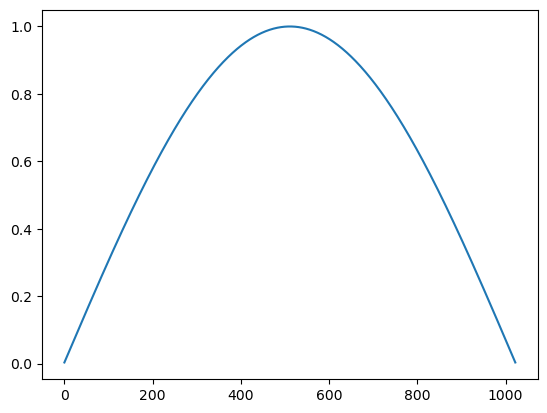

In [31]:
plt.plot(dst_jax(coef_test[1:]))

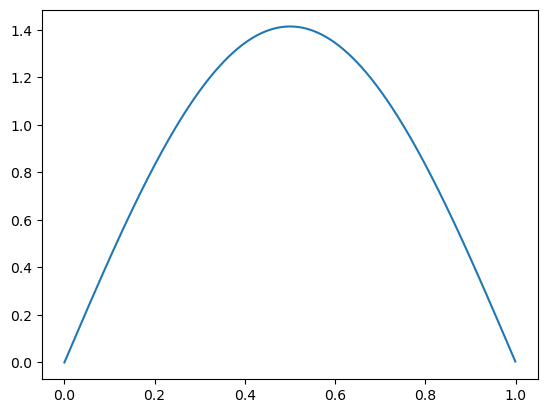

In [32]:
domain = jnp.linspace(0, 1, n_coef, endpoint=False)
plt.plot(domain, evaluate_function_sine(domain, freq, 1.0))

In [152]:
inverse_sine_transform(coef_test[1:])

Array([-0.        ,  0.00307096,  0.00614188, ..., -0.00921275,
       -0.00614188, -0.00307096], dtype=float64)

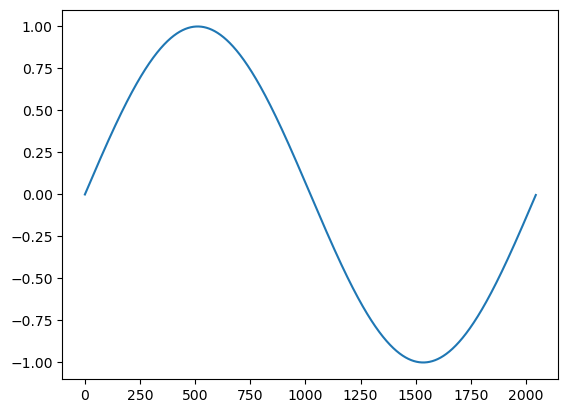

In [155]:
plt.plot(inverse_sine_transform(coef_test[1:]))

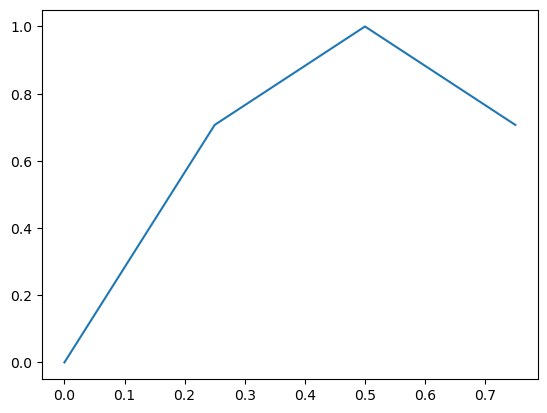

In [31]:
plt.plot(domain, evaluate_function_sine(domain, freq, 1.0))

# Old

In [ ]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [ ]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n))) # Removing the last spurious element 

# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

In [ ]:
def evaluate_function_sine(x, k ,c):
    return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
def evaluate_basis_sine(x,c):
    frequencies = jnp.arange(1, c.shape[0]+1)
    return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

In [ ]:
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**13
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
print(n_coef)

frequencies = jnp.arange(0, n_coef)
coef_f = jnp.hstack([0.0, random.normal(key, shape= (n_coef-1,))]) # We set the first coefficient to zero as it corresponds to the constant term
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


8192


In [ ]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [ ]:
discrete_sine_transform(u_values), coef_u[:]

(Array([-0.00000000e+00, -8.00026028e-05, -4.66696176e-01, ...,
        -5.57578299e-11,  5.95002631e-11, -5.66143498e-12], dtype=float64),
 Array([ 0.00000000e+00, -4.66405723e-01, -8.81663398e-01, ...,
         4.84041776e-09, -3.80672092e-08,  8.17818791e-08], dtype=float64))

In [ ]:
jnp.mean(jnp.abs(u_transform - coef_u))

Array(0.00655008, dtype=float64)

In [ ]:
domain_finest.shape, coef_u.shape

((8192,), (8192,))

In [ ]:
discrete_sine_transform(u_values)[:10], coef_u[:10]

(Array([-0.00000000e+00, -8.00026028e-05, -4.66696176e-01, -8.81526883e-01,
         9.88306684e-02, -6.50694938e-02, -2.81457649e-01, -5.78215406e-01,
         5.94869249e-02,  2.60063199e-01], dtype=float64),
 Array([ 0.        , -0.46640572, -0.8816634 ,  0.09857175, -0.06489187,
        -0.28128293, -0.57848921,  0.05854402,  0.26012406, -0.10816874],      dtype=float64))

In [ ]:
key = random.PRNGKey(635)
nu = 0.01
n_coef = 2**10
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
print(n_coef)

frequencies = jnp.arange(1, n_coef+1)
coef_f = random.normal(key, shape= (n_coef,))
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

1024


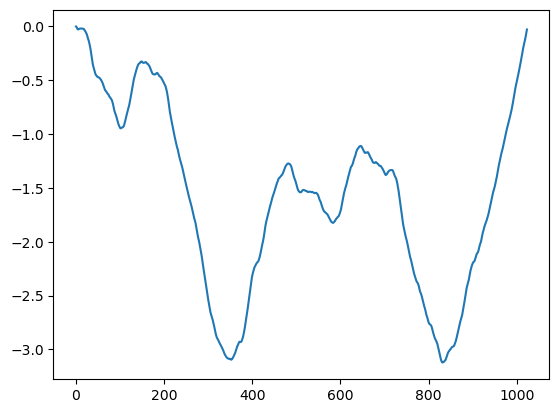

In [ ]:
plt.plot(u_values)

In [ ]:
discrete_sine_transform(u_values), coef_u

(Array([-0.00000000e+00, -1.58930310e+00,  1.86789309e-01, ...,
         5.08989794e-08,  6.51205360e-09,  3.91043412e-09], dtype=float64),
 Array([-1.59053696e+00,  1.86124965e-01, -4.46838235e-01, ...,
         8.98179769e-06,  2.04883469e-05,  1.57002229e-06], dtype=float64))

In [ ]:
# We include both 0 and 1 in the domain
domain_finest = jnp.linspace(lower,upper,n_coef+1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

In [ ]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [ ]:
jnp.mean((u_transform[:-1] - coef_u)**2), jnp.mean((f_transform[:-1] - coef_f)**2)

(Array(0.000306, dtype=float64), Array(1.53517604, dtype=float64))

In [ ]:
# We do not include both 0 and 1 in the domain
domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

In [ ]:
domain_finest.shape

(8193,)

In [ ]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [ ]:
jnp.mean((u_transform[:-1] - coef_u)**2), jnp.mean((f_transform[:-1] - coef_f)**2)

(Array(0.00030589, dtype=float64), Array(1.32921151, dtype=float64))

In [ ]:
# We do not include both 0 and 1 in the domain
domain_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

In [ ]:
domain_finest

Array([0.00000000e+00, 1.22070312e-04, 2.44140625e-04, ...,
       9.99633789e-01, 9.99755859e-01, 9.99877930e-01], dtype=float64)

In [ ]:
n_coef, domain_finest.shape, u_values.shape

(8192, (8192,), (8192,))

In [ ]:
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))

In [ ]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [ ]:
u_transform.shape, coef_f.shape

((8193,), (8192,))

In [ ]:
jnp.mean((u_transform[1:] - coef_u)**2), jnp.mean((f_transform[1:] - coef_f)**2)

(Array(1.3878491e-10, dtype=float64), Array(0.49758865, dtype=float64))

In [ ]:
u_values

Array([0.        , 0.00196666, 0.00387146, ..., 0.00388946, 0.00261485,
       0.00131249], dtype=float64)

In [ ]:
f_test = lambda x : x**2+1 + x**3 - 3*x**4 + x

In [ ]:
f_test_values = f_test(domain_finest)

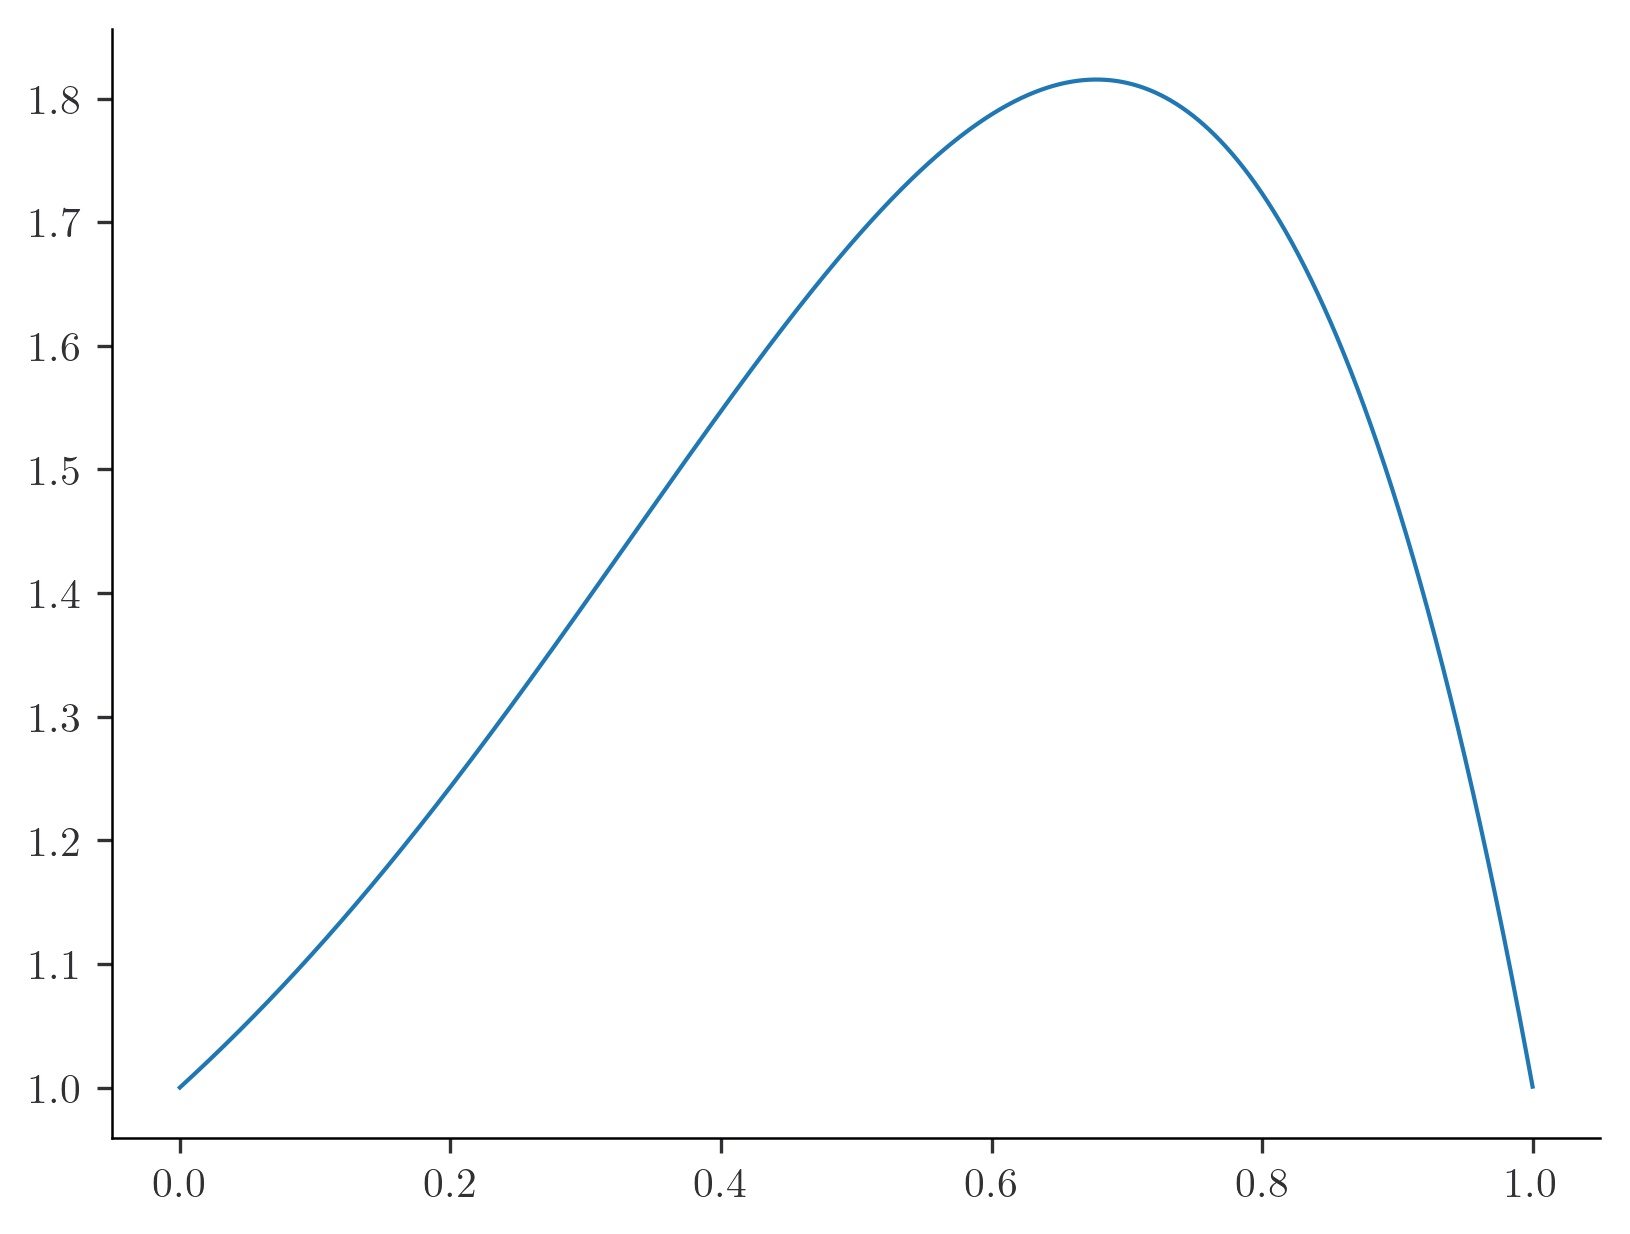

In [ ]:
plt.plot(domain_finest, f_test_values)

In [ ]:
f_transformed = discrete_sine_transform(f_test_values)

(16384,)
(8193,)


In [ ]:
# Manual computation of the using quadrature
from scipy import integrate

domain_full = jnp.linspace(lower,upper,n_coef)

In [ ]:
def integrate_sine(points, k, f_values):
     G = f_values*jnp.sqrt(2)*jnp.sin(jnp.pi*k*points)
     return integrate.trapezoid(G, points)

In [ ]:
f_values = f_test(domain_full)

In [ ]:
max_freq = n_coef
k_list = jnp.arange(0, max_freq)
integral_manual = jnp.array([integrate_sine(domain_full, k,  f_test(domain_full)) for k in k_list])

In [ ]:
jnp.mean((integral_manual - f_transformed[:max_freq])**2)

Array(1.86504091e-12, dtype=float64)

In [ ]:
k = 2
integrate_sine(domain_full, k, f_test(domain_full))

-0.17103959026040072

In [ ]:
f_transformed[k]

Array(0.44338267, dtype=float64)

In [ ]:
domain_full.shape

(8192,)

In [ ]:
domain_finest[-1]

Array(0.99987793, dtype=float64)

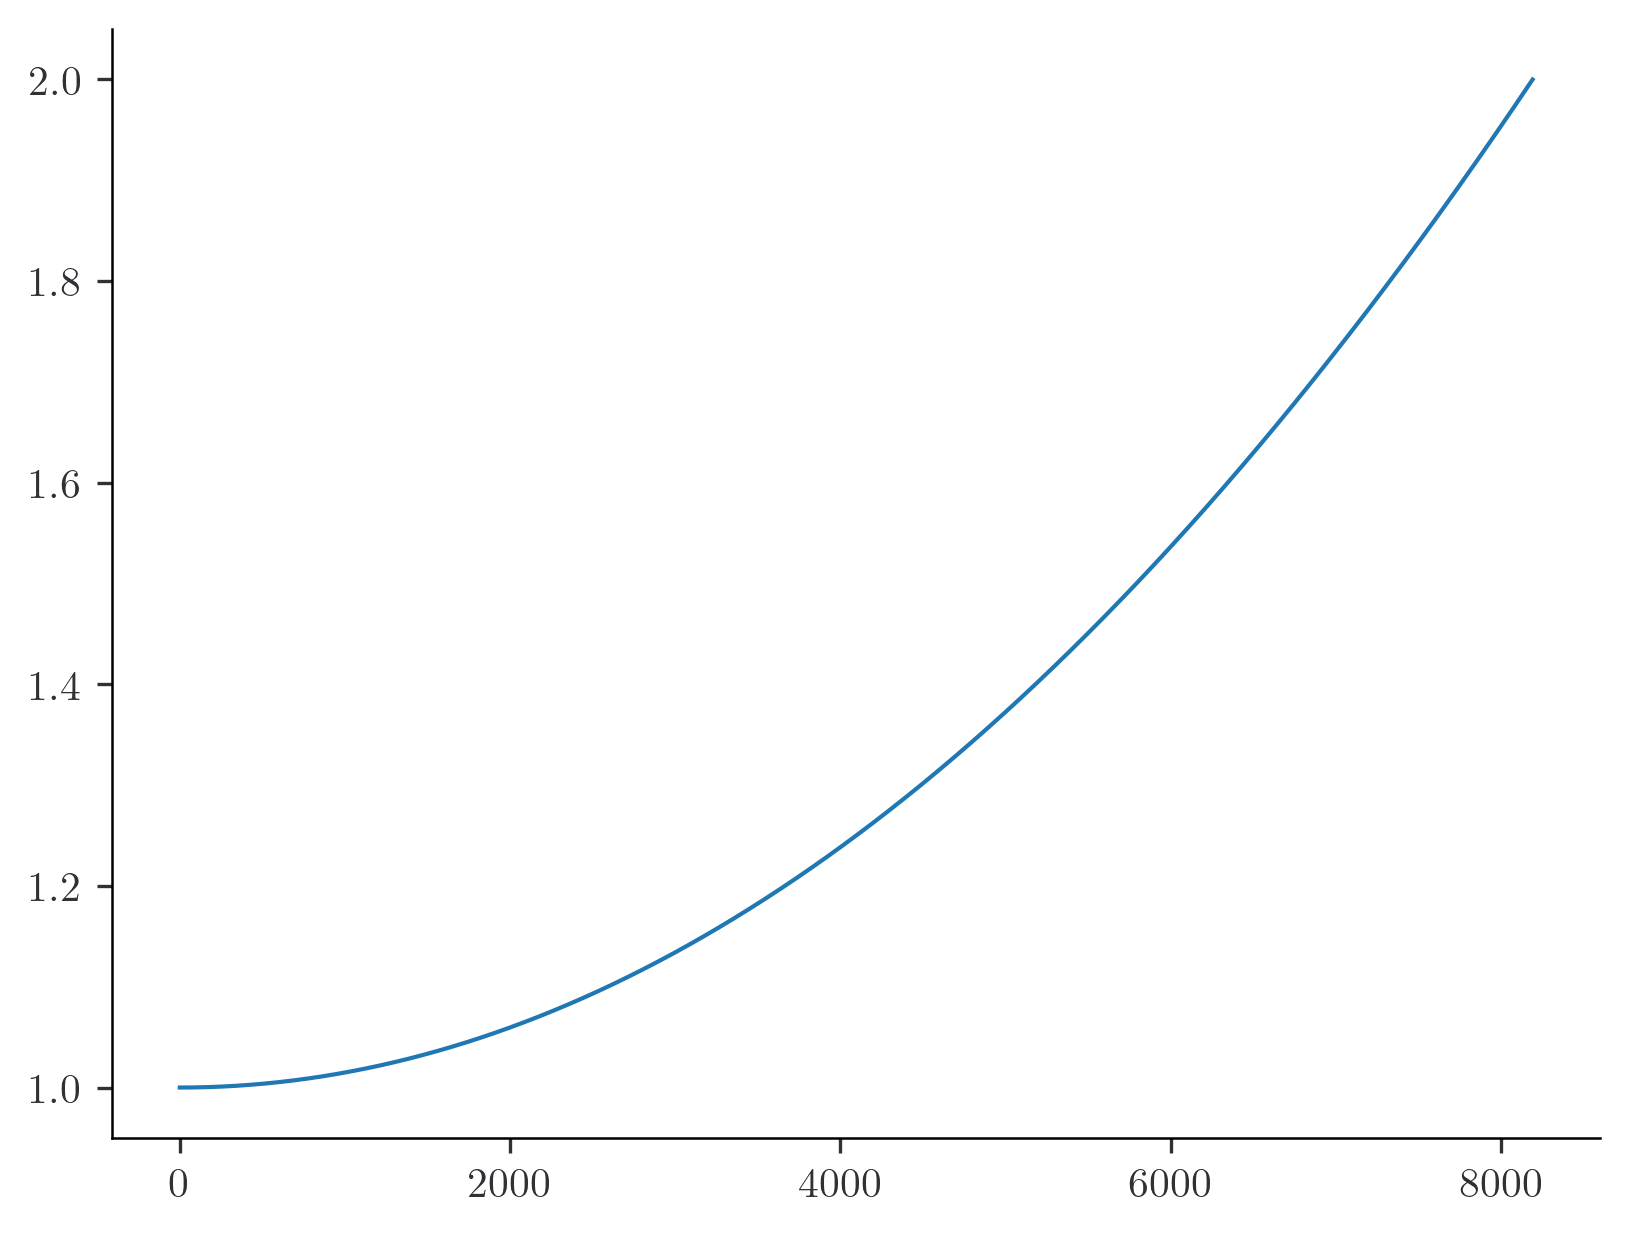

In [ ]:
plt.plot(f_test_values)

In [ ]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

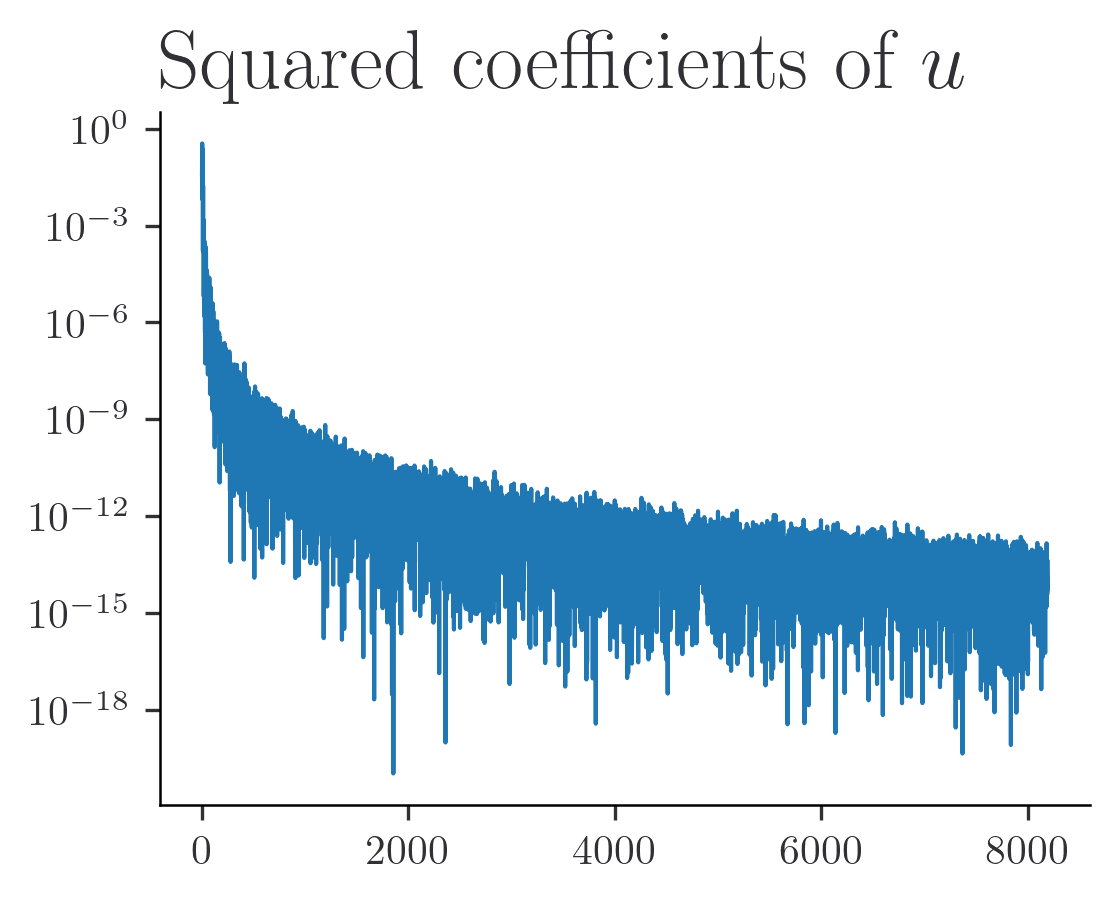

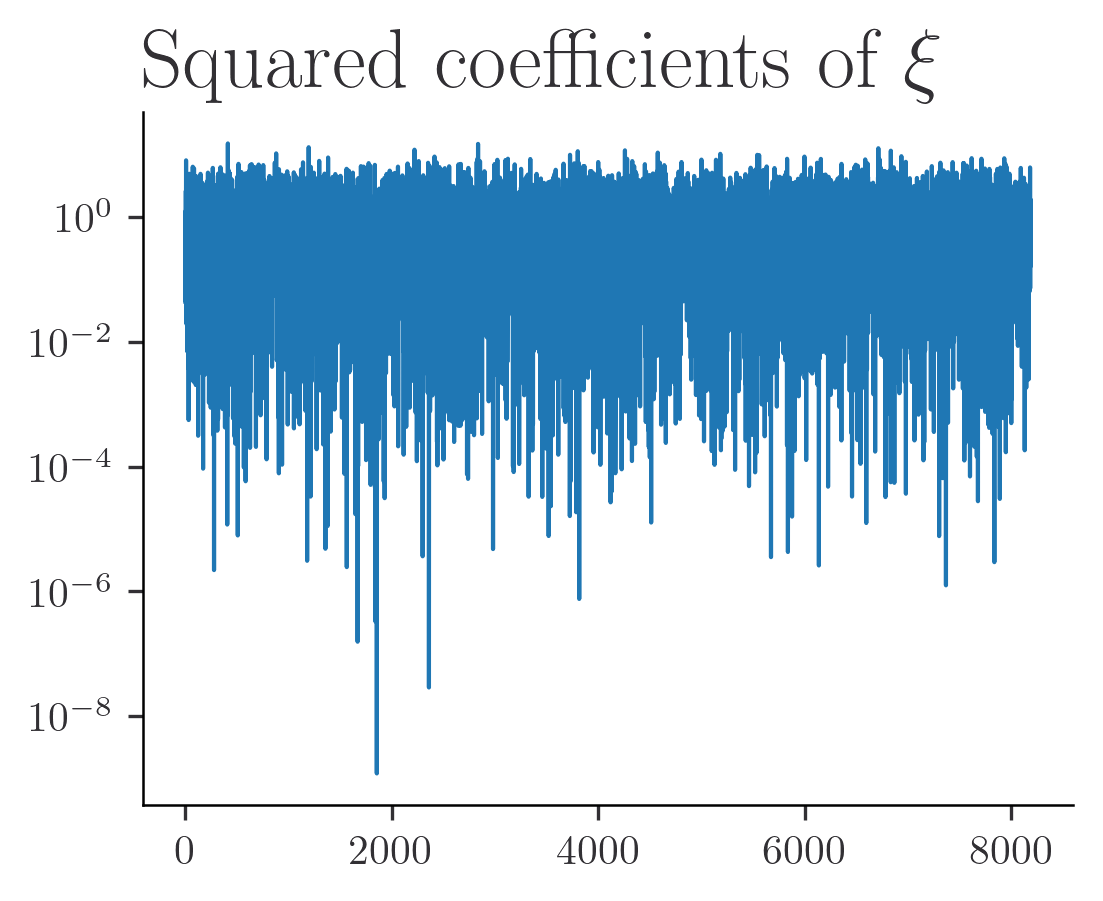

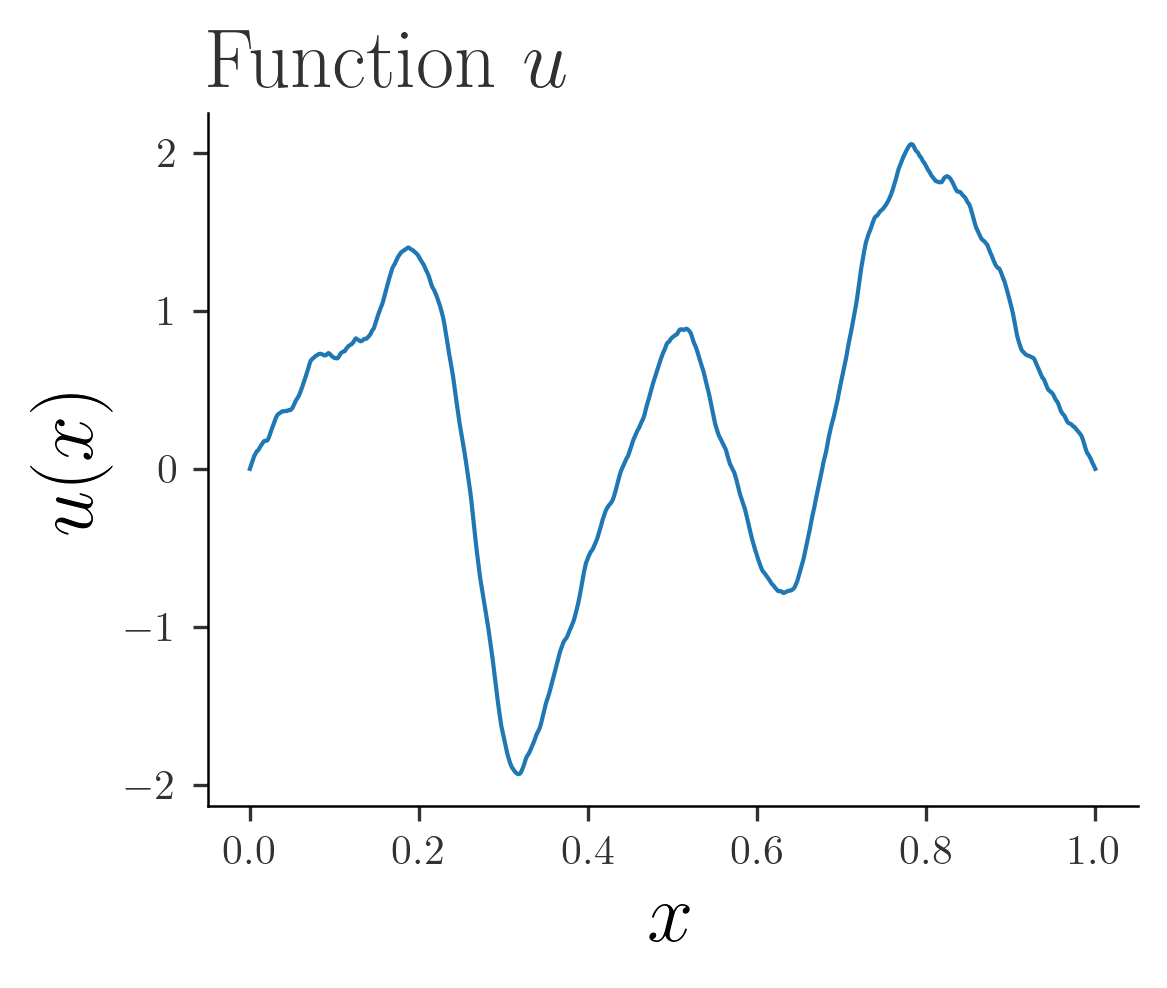

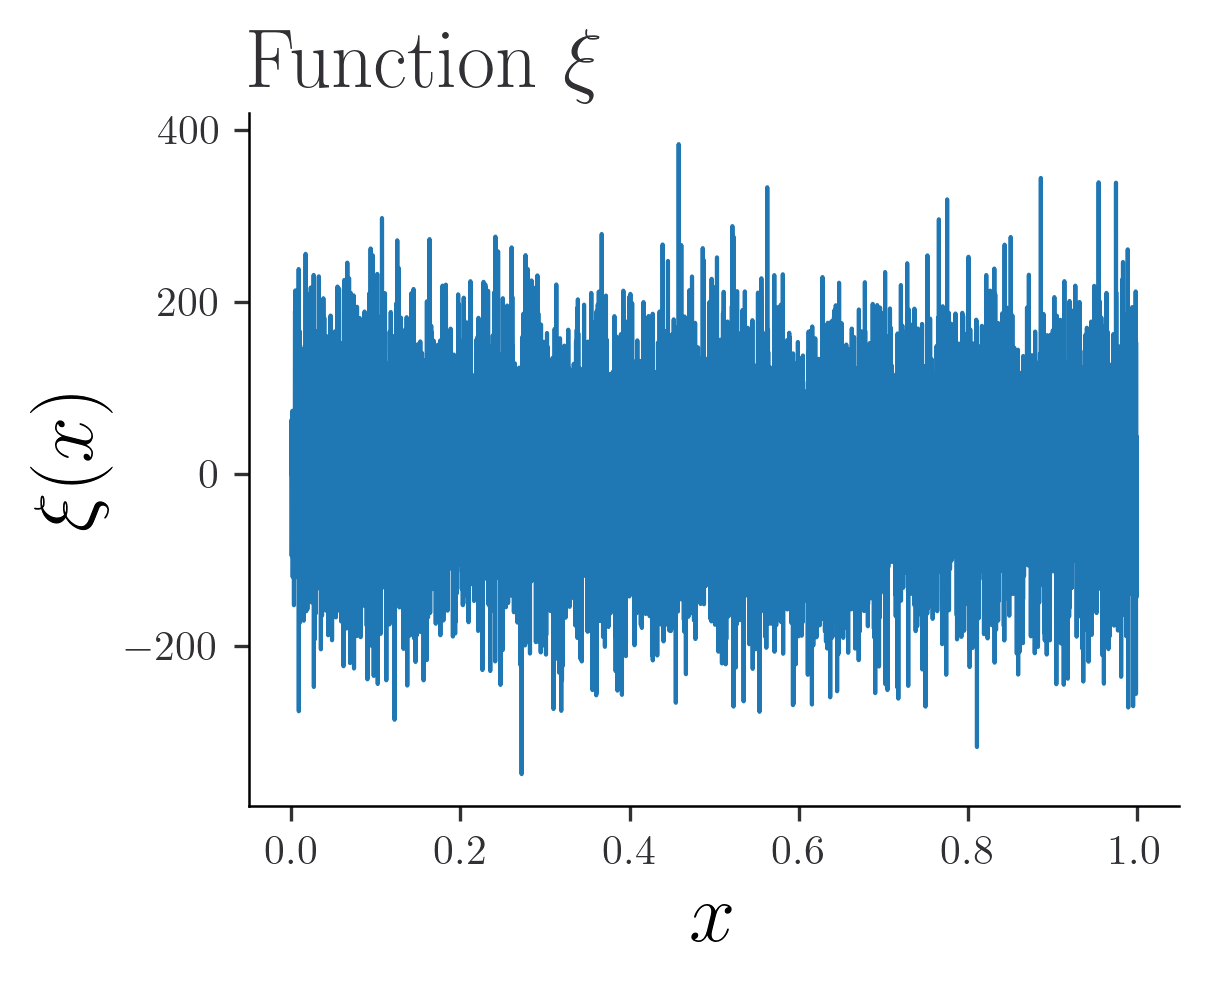

In [ ]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()